In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import shap
from pathlib import Path
from itertools import cycle
from matplotlib.lines import Line2D
import matplotlib as mpl
import mplhep as mh
mh.style.use("CMS")

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [2]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

In [3]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_gen.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_Ref.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p0113.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p016.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p03.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p045.h5"

photon_PU0_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgogen_filtered.h5"
photon_PU0_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgocl3d_Ref_filtered.h5"
photon_PU0_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgocl3d_p0113_filtered.h5"
photon_PU0_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgocl3d_p016_filtered.h5"
photon_PU0_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgocl3d_p03_filtered.h5"
photon_PU0_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU0_newalgocl3d_p045_filtered.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_gen.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_Ref.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p0113.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p016.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p03.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p045.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_gen.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_Ref.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p0113.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p016.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p03.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p045.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_Ref.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p0113.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p016.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p03.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p045.h5"

In [4]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [25]:
photon_df_Ref0 = ana.load_and_filter_hdf_path(photon_PU0_gen, photon_PU0_cl3d_Ref)
photon_df_p01130 = ana.load_and_filter_hdf_path(photon_PU0_gen, photon_PU0_cl3d_p0113)
photon_df_p0160 = ana.load_and_filter_hdf_path(photon_PU0_gen, photon_PU0_cl3d_p016)
photon_df_p030 = ana.load_and_filter_hdf_path(photon_PU0_gen, photon_PU0_cl3d_p03)
photon_df_p0450 = ana.load_and_filter_hdf_path(photon_PU0_gen, photon_PU0_cl3d_p045)

In [5]:
pd.set_option("display.min_rows", 50)
pd.set_option("display.max_columns", 50)

In [5]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

In [6]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [17]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [6]:
def filtering(df, prefix, thr):
    df['delta_r'] = ana.delta_r(df[rf"cl3d_{prefix}_eta"], df[rf"cl3d_{prefix}_phi"], df['genpart_exeta'], df['genpart_exphi'])
    df = df[df['delta_r'] <=thr]
    df = (df.sort_values(by=["event", f"cl3d_{prefix}_energy"],ascending=[True, False] ))  # event fixed, energy high → low).reset_index(drop=True
    eta_cl = df[rf"cl3d_{prefix}_eta"]
    eta_ref = df[rf"genpart_exeta"]   # change if needed
    mask = (eta_cl * eta_ref) > 0   # same sign (both + or both -)
    df = df.loc[mask].reset_index(drop=True)
    df = df.sort_values(["event", "genpart_gen", f'cl3d_{prefix}_energy'], ascending=[True, True, False])
    df = df.drop_duplicates(subset=["event", "genpart_gen"], keep="first")
    df = (df.sort_values(["event", f'cl3d_{prefix}_energy'], ascending=[True, False]).groupby("event", as_index=False).head(2).reset_index(drop=True))
    return df

In [7]:
photon_df_p045_filtered = filtering(photon_df_p045, 'p045Tri',0.1)
photon_df_p03_filtered = filtering(photon_df_p03, 'p03Tri',0.1)
photon_df_p016_filtered = filtering(photon_df_p016, 'p016Tri',0.1)
photon_df_p0113_filtered = filtering(photon_df_p0113, 'p0113Tri',0.1)
photon_df_Ref_filtered = filtering(photon_df_Ref, 'Ref',0.1)

In [84]:
def filter_by_delta_r(df, prefix):
    required_columns = [f"cl3d_{prefix}_eta", f"cl3d_{prefix}_phi", "genpart_exeta", "genpart_exphi", f"cl3d_{prefix}_energy", "event", "gen_pt",]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    df = df.copy()
    df['delta_r'] = ana.delta_r(df[rf"cl3d_{prefix}_eta"], df[rf"cl3d_{prefix}_phi"], df['genpart_exeta'], df['genpart_exphi'])
    m_sign = (df[f"cl3d_{prefix}_eta"] * df["genpart_exeta"]) > 0.0
    df = df[m_sign]
    # build per-row ΔR threshold
    if prefix in ["Ref", "p0113Tri", "p016Tri"]:
        dr_thr = 0.10
        m_dr = df["delta_r"] < dr_thr
    elif prefix in [ "p03Tri", "p045Tri"]:
        # gen-pt dependent
        dr_thr_arr = np.where(df["gen_pt"].to_numpy() < 70.0, 0.1, 0.50)
        m_dr = df["delta_r"].to_numpy() < dr_thr_arr
    else:
        raise ValueError(f"Unknown prefix '{prefix}' for ΔR threshold rules")
    df_filtered = df[m_dr]
    df = df.sort_values(["event", "genpart_gen", f'cl3d_{prefix}_energy'], ascending=[True, True, False])
    df = df.drop_duplicates(subset=["event", "genpart_gen"], keep="first")
    df = (df.sort_values(["event", f'cl3d_{prefix}_energy'], ascending=[True, False]).groupby("event", as_index=False).head(2).reset_index(drop=True))
    return df

In [85]:
photon_df_p03_filtered = filter_by_delta_r(photon_df_p03, 'p03Tri')
photon_df_p045_filtered = filter_by_delta_r(photon_df_p045, 'p045Tri')

In [ ]:
photon_df_p045_filtered = filtering(photon_df_p045, 'p045Tri',0.1)
photon_df_p03_filtered = filtering(photon_df_p03, 'p03Tri',0.1)

In [28]:
dr_vals = np.array([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])


/tmp/ipykernel_3021428/347336804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_r'] = ana.delta_r(df[rf"cl3d_{prefix}_eta"], df[rf"cl3d_{prefix}_phi"], df['genpart_exeta'], df['genpart_exphi'])


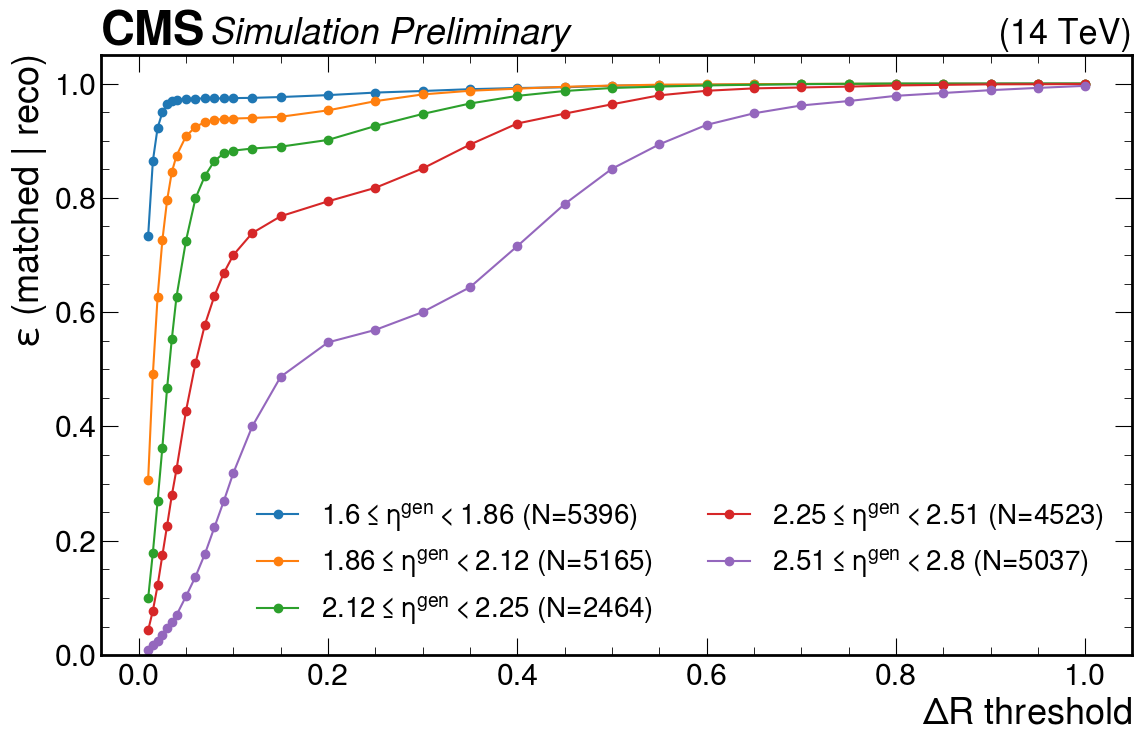

In [37]:
pt_bins = np.array([1.60, 1.86, 2.12, 2.25, 2.51, 2.80])  # edit to taste
eff_map = np.zeros((len(pt_bins)-1, len(dr_vals)), dtype=float)
n0_bins = np.zeros(len(pt_bins)-1, dtype=int)
pair_cols = ["event", "genpart_gen"]
for ib in range(len(pt_bins)-1):
    lo, hi = pt_bins[ib], pt_bins[ib+1]

    df_bin = photon_df_p045[(photon_df_p045["genpart_exeta"] >= lo) & (photon_df_p045["genpart_exeta"] < hi)]

    n0 = df_bin.drop_duplicates(pair_cols).shape[0]
    n0_bins[ib] = n0

    if n0 == 0:
        continue

    for idr, dr in enumerate(dr_vals):
        df_cut = filtering(df_bin, "p045Tri", dr)
        n_pass = df_cut.drop_duplicates(pair_cols).shape[0]
        eff_map[ib, idr] = n_pass / n0

# ---- plot curves ----
plt.figure(figsize=(12,8))
for ib in range(len(pt_bins)-1):
    lo, hi = pt_bins[ib], pt_bins[ib+1]
    plt.plot(dr_vals, eff_map[ib], marker="o",
             label=rf"${lo:g}\leq \eta^{{gen}}<{hi:g}$ (N={n0_bins[ib]})")

plt.xlabel(r"$\Delta R$ threshold")
plt.ylabel(r"$\epsilon$ (matched | reco)")
plt.ylim(0, 1.05)
plt.legend(ncol=2, fontsize=20)
mh.cms.label("Preliminary", data=False, com=14)
plt.tight_layout()
plt.savefig("eff_vs_deltaR_by_genEta_p045.png", dpi=200)
plt.show()

Ref: n0=764
p0113: n0=764
p016: n0=764
p03: n0=764
p045: n0=764


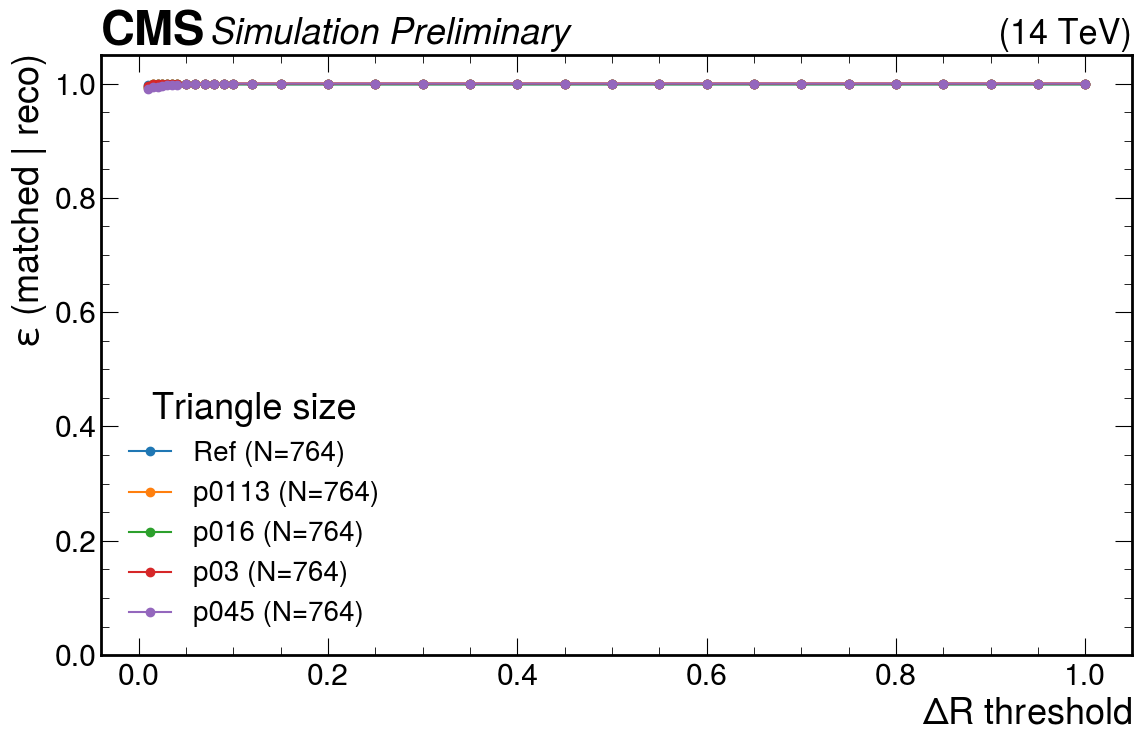

In [ ]:
# Your dfs
dfs = {
    "Ref":   (photon_df_Ref,   "cl3d_Ref", "Ref"),
    "p0113": (photon_df_p0113, "cl3d_p0113Tri", "p0113Tri"),
    "p016":  (photon_df_p016,  "cl3d_p016Tri", "p016Tri"),
    "p03":   (photon_df_p03,   "cl3d_p03Tri", "p03Tri"),
    "p045":  (photon_df_p045,  "cl3d_p045Tri", "p045Tri"),
}
plt.figure(figsize=(12, 8))

pair_cols = ["event", "genpart_gen"]  # <-- adjust if your column name differs

for label, (df, prefix, pref) in dfs.items():
    n0 = df.drop_duplicates(pair_cols).shape[0]   # baseline unique (event, genpart_gen)
    eff = []

    for dr in dr_vals:
        df_cut = filtering(df, pref, dr)
        n_pass = df_cut.drop_duplicates(pair_cols).shape[0]  # numerator unique pairs
        eff.append(n_pass / n0 if n0 > 0 else 0.0)

    eff = np.array(eff)

    print(f"{label}: n0={n0}")
    plt.plot(dr_vals, eff, marker="o", label=f"{label} (N={n0})")

plt.xlabel(r"$\Delta R$ threshold")
plt.ylabel(r"$\epsilon$ (matched | reco)")
plt.ylim(0, 1.05)
plt.legend(title="Triangle size", fontsize=20)
mh.cms.label("Preliminary", data=False, com=14)
plt.tight_layout()
plt.savefig("eff_vs_deltaR_allTrianglespu0.png", dpi=200)
plt.show()


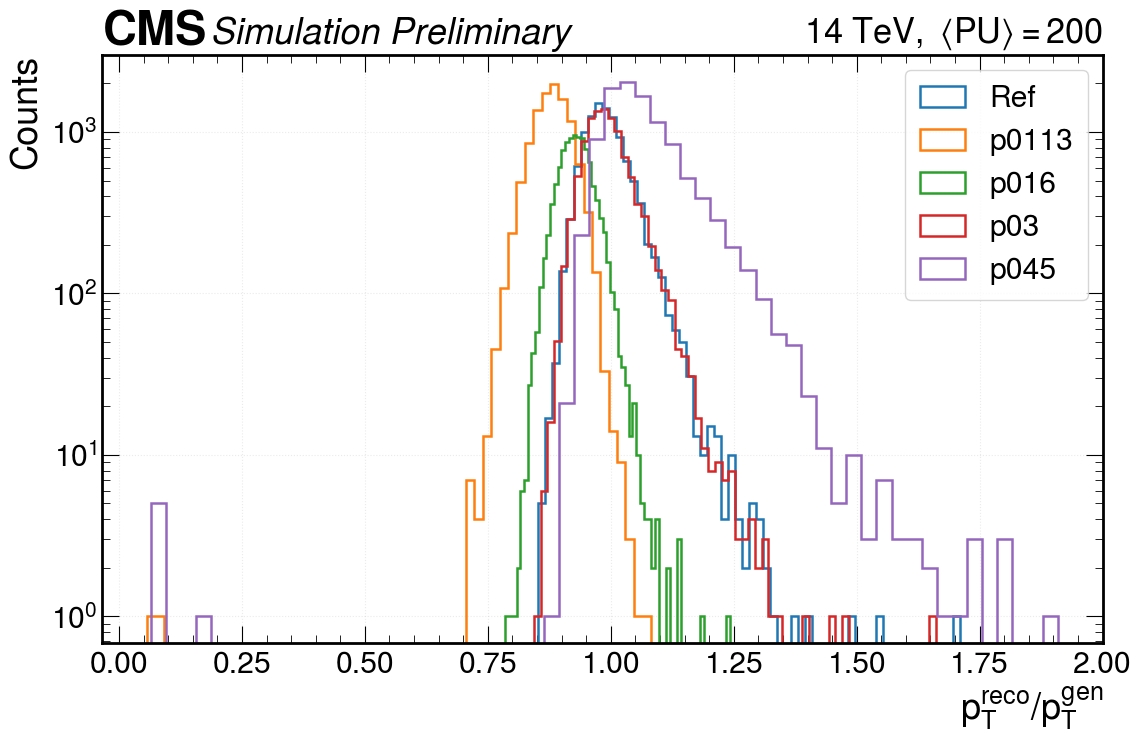

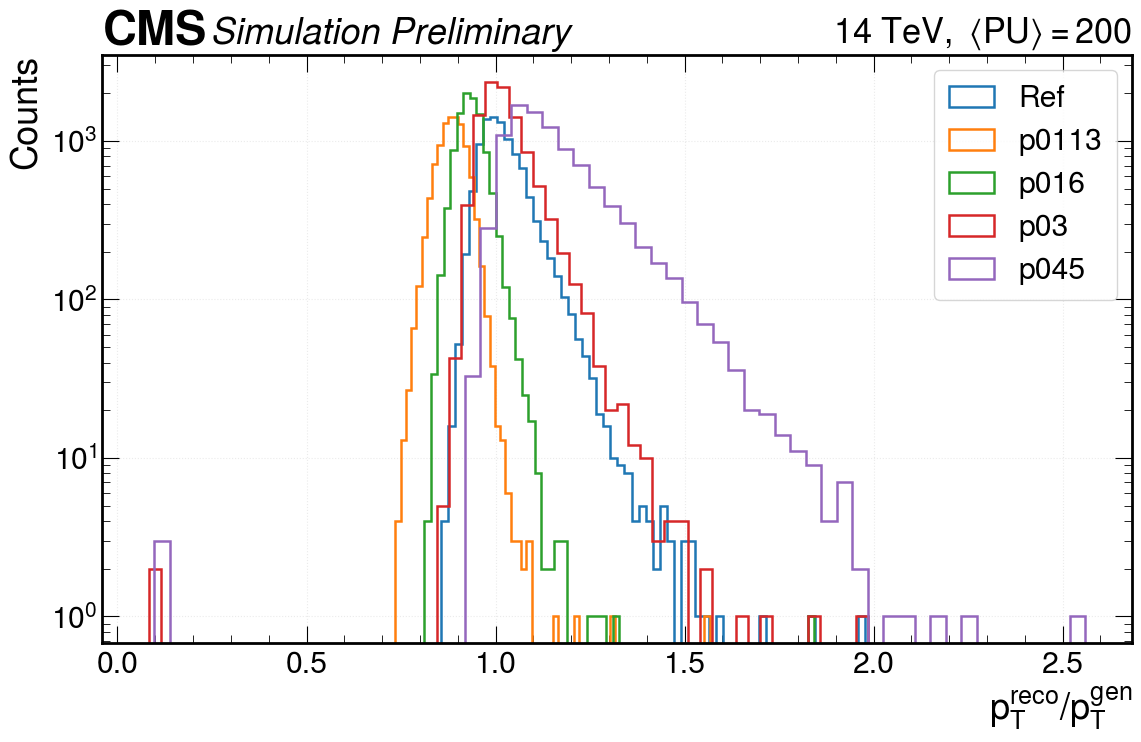

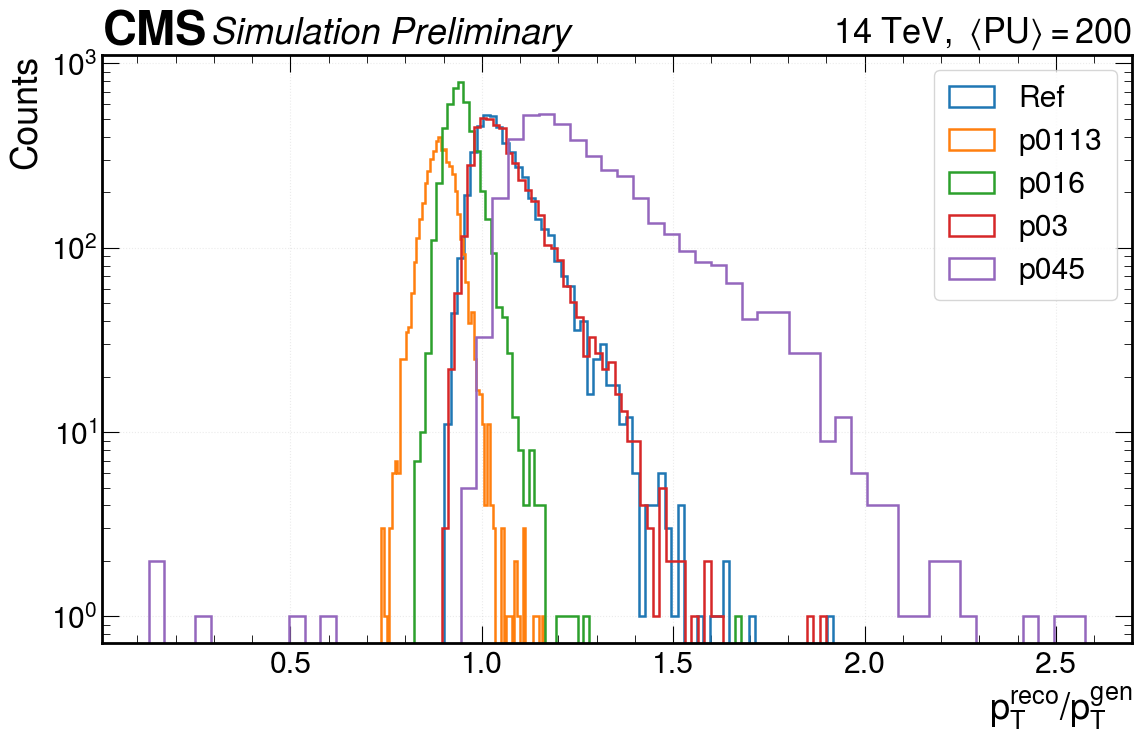

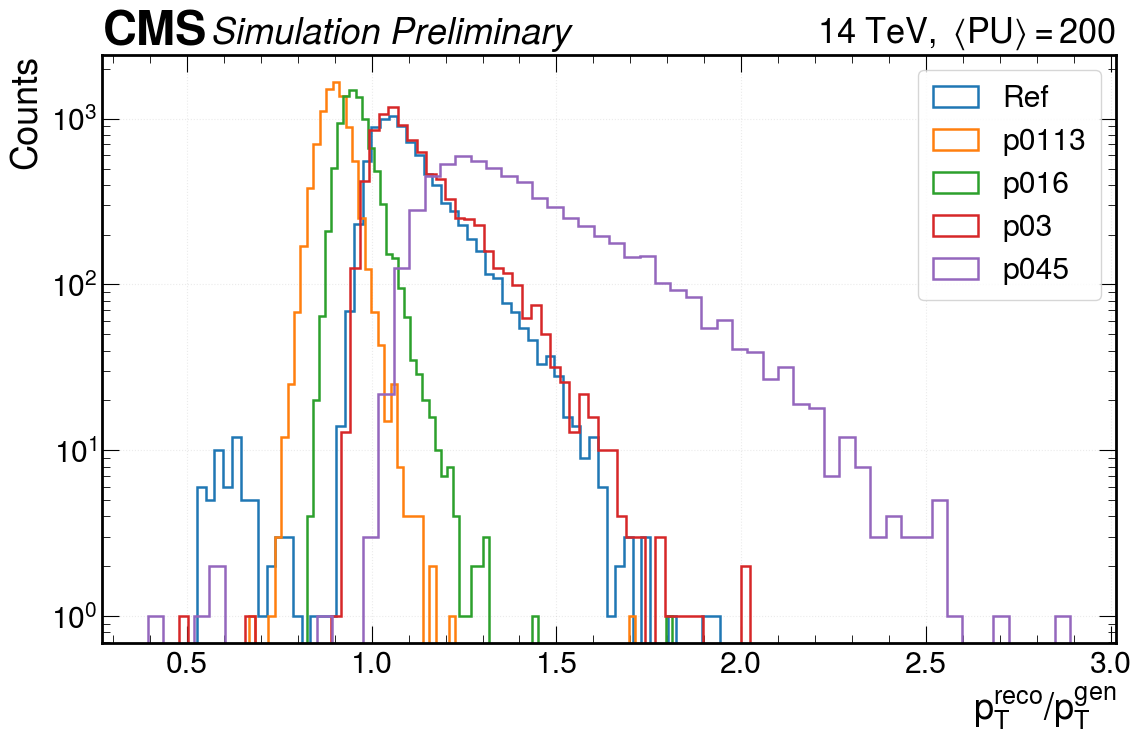

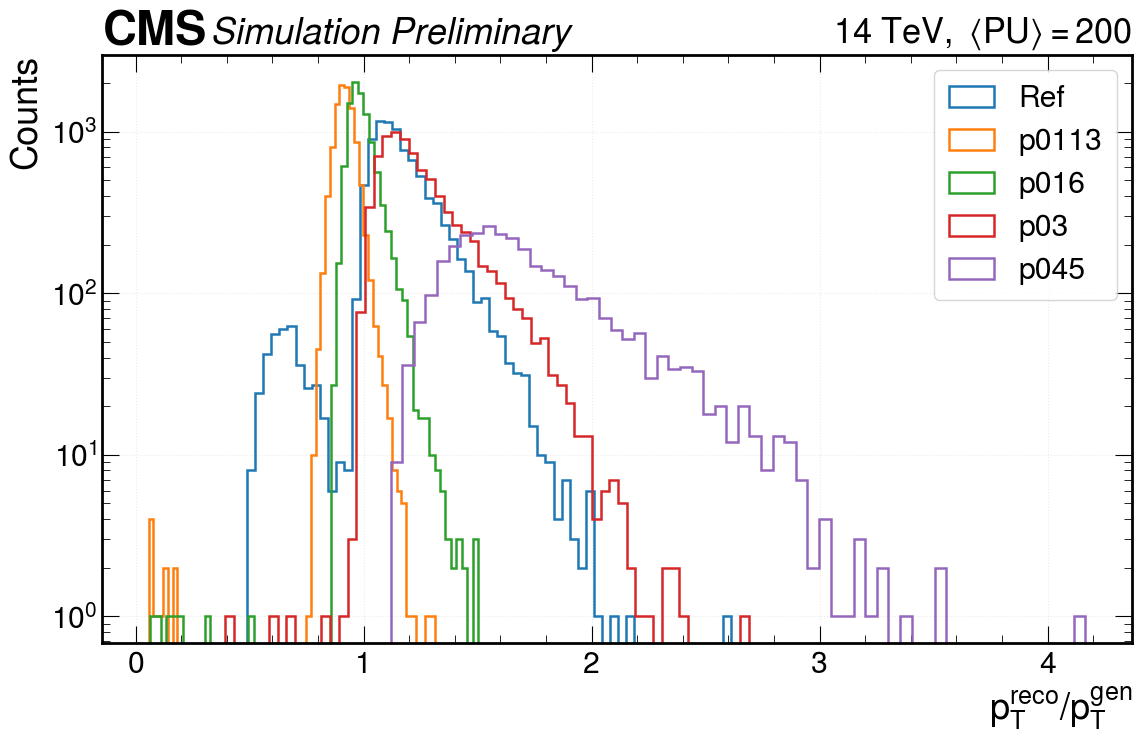

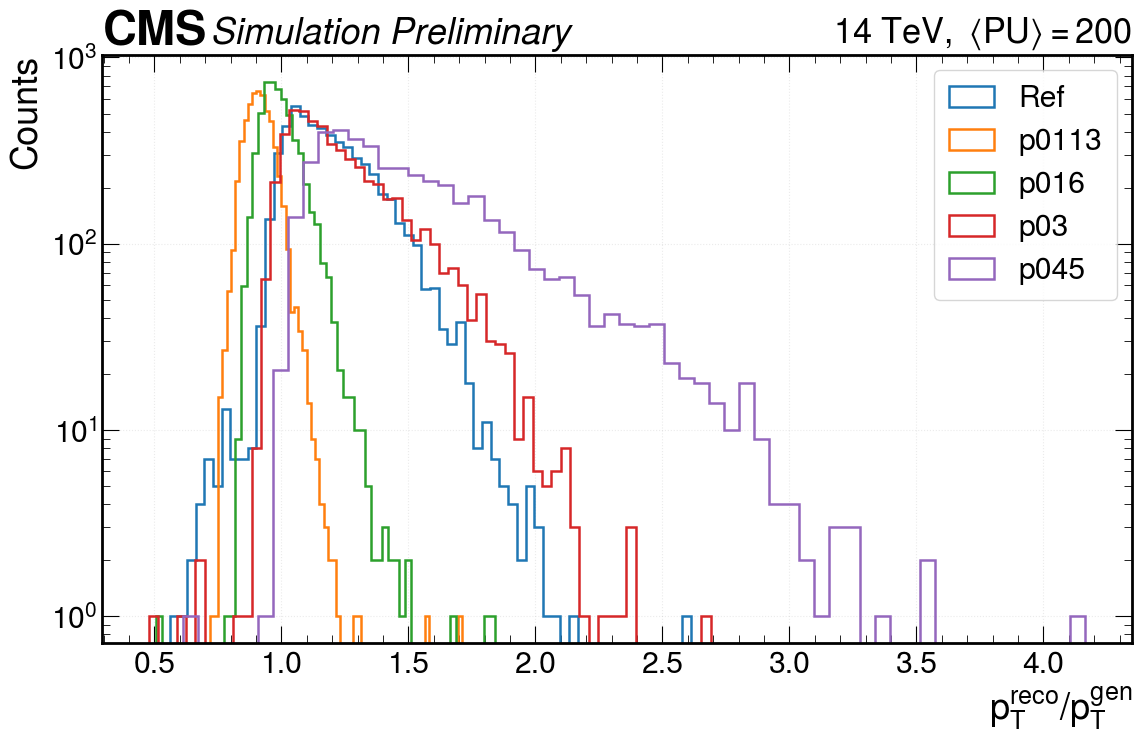

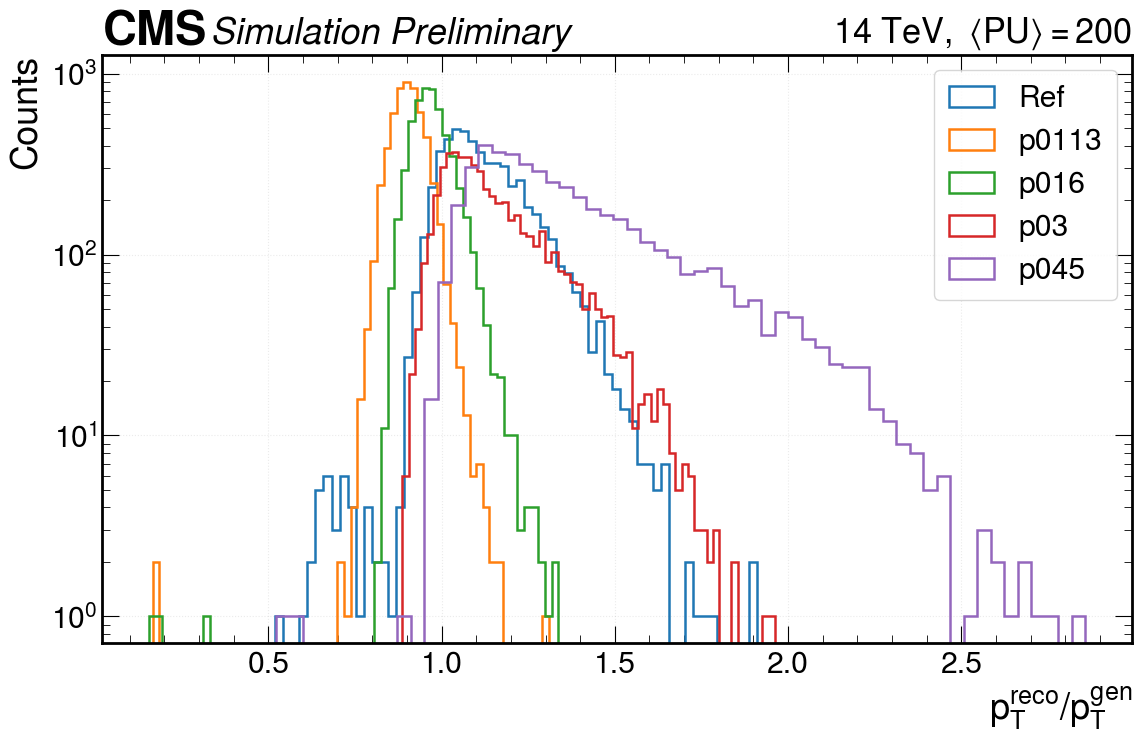

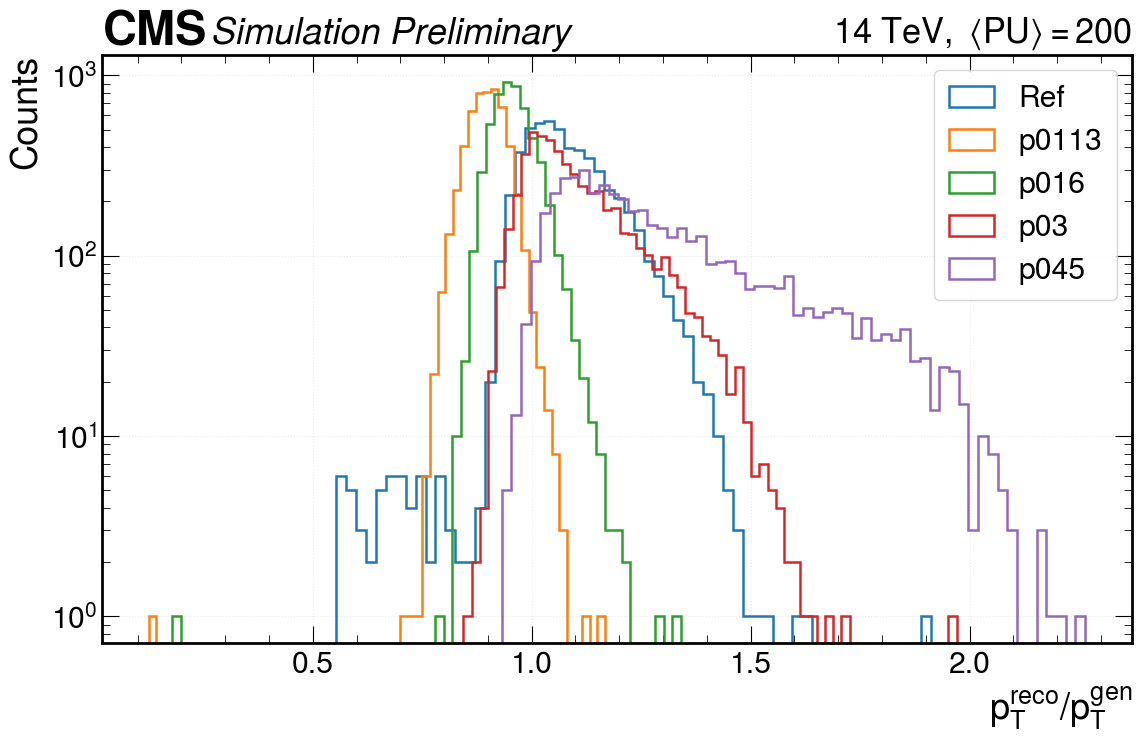

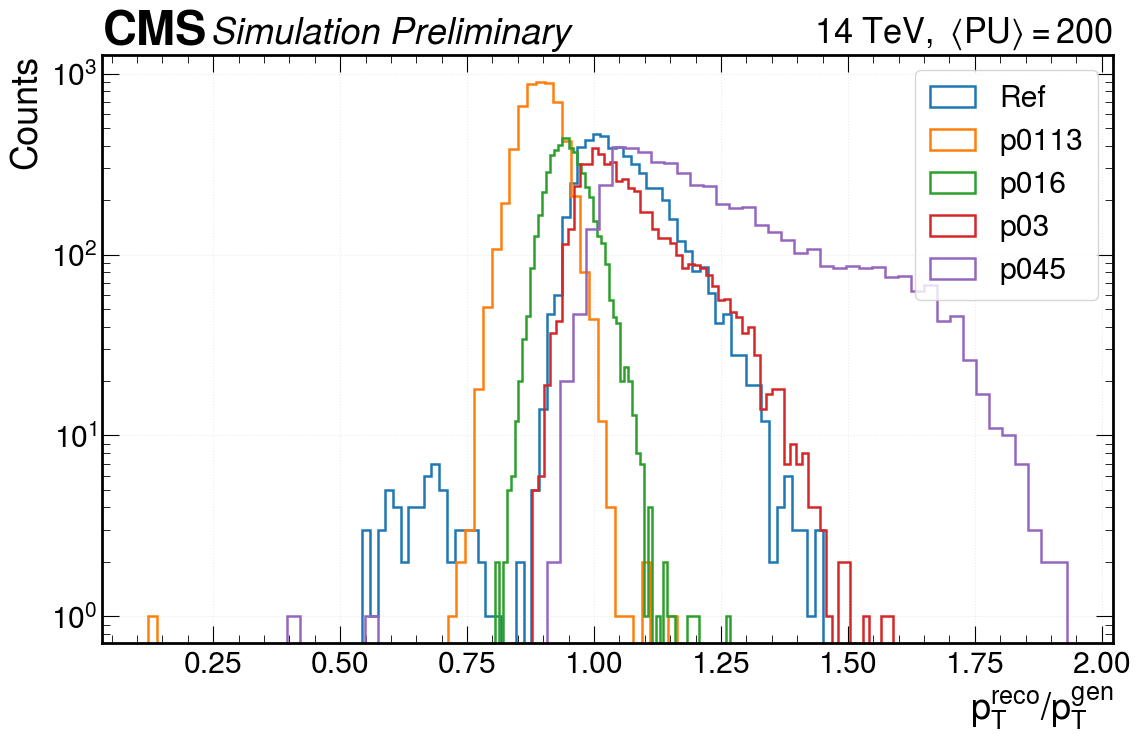

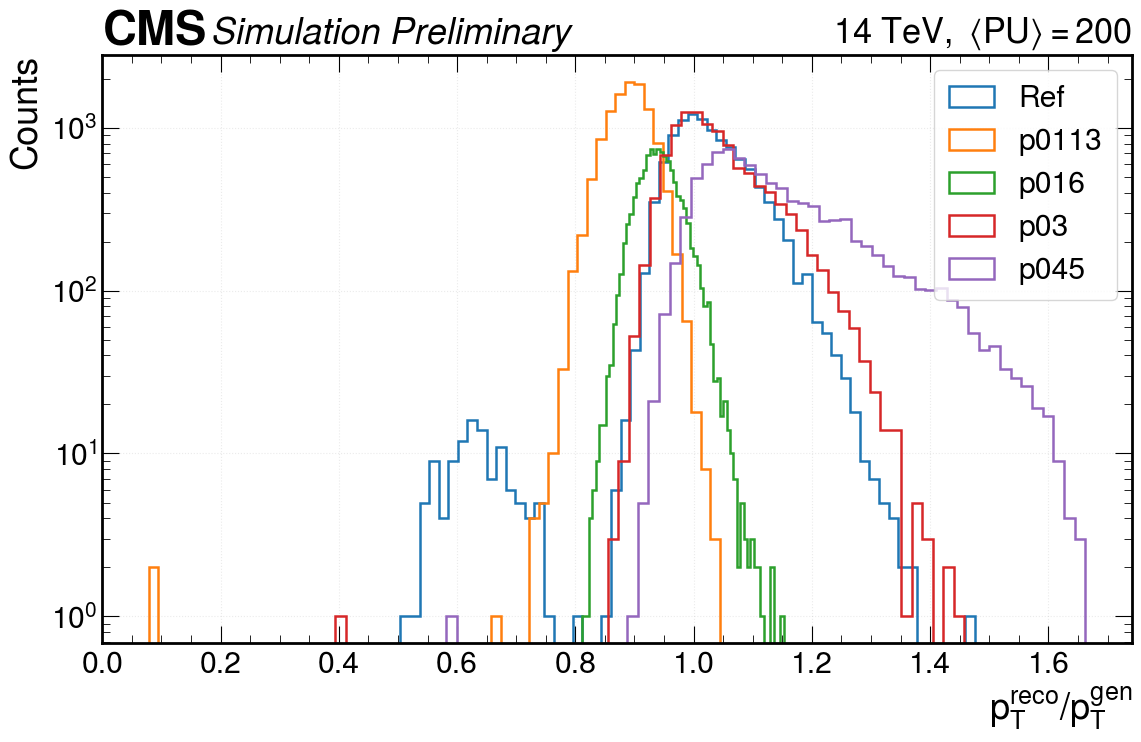

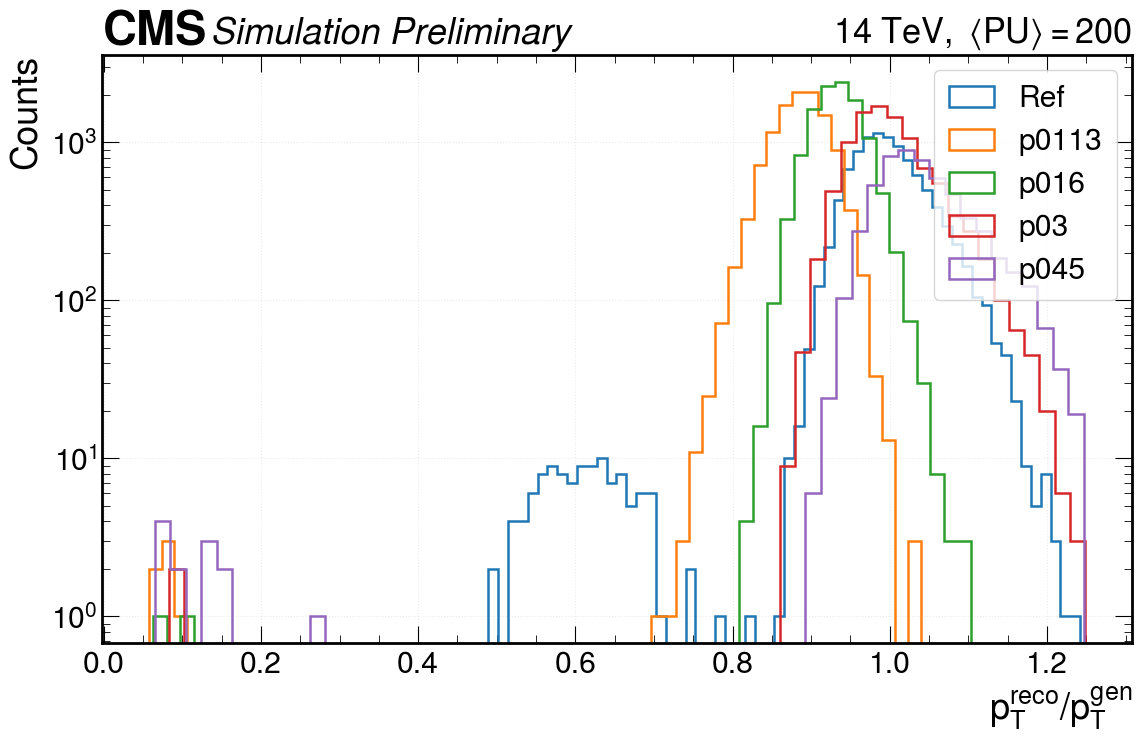

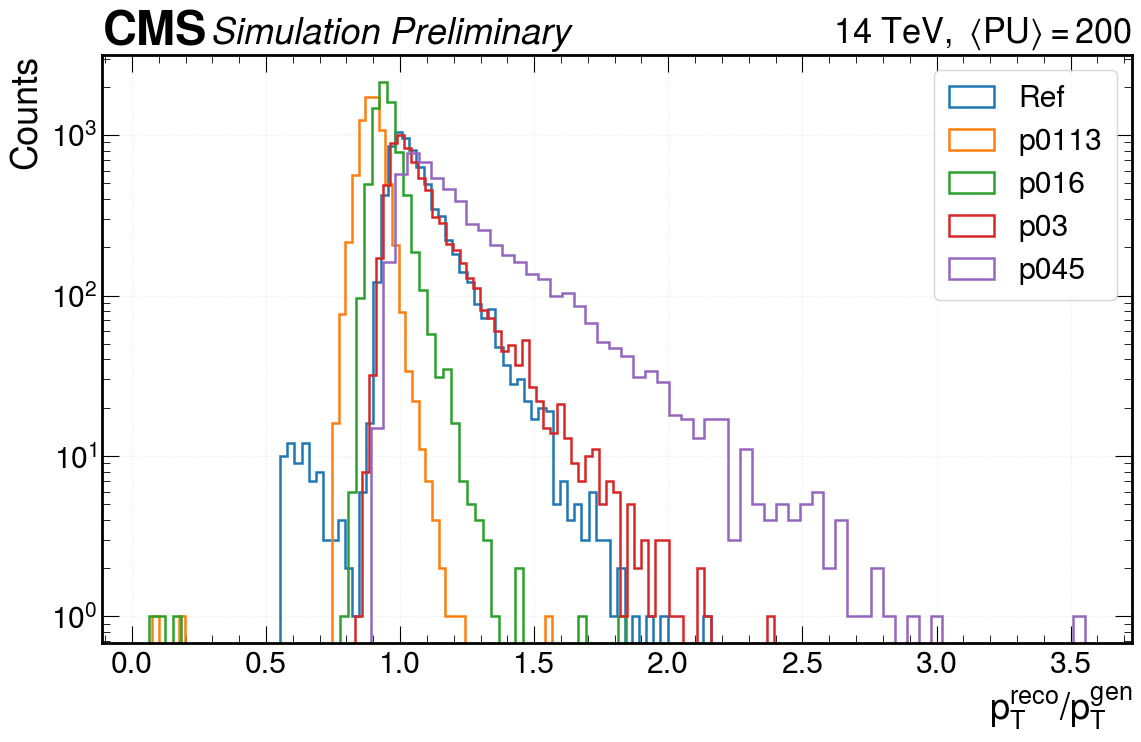

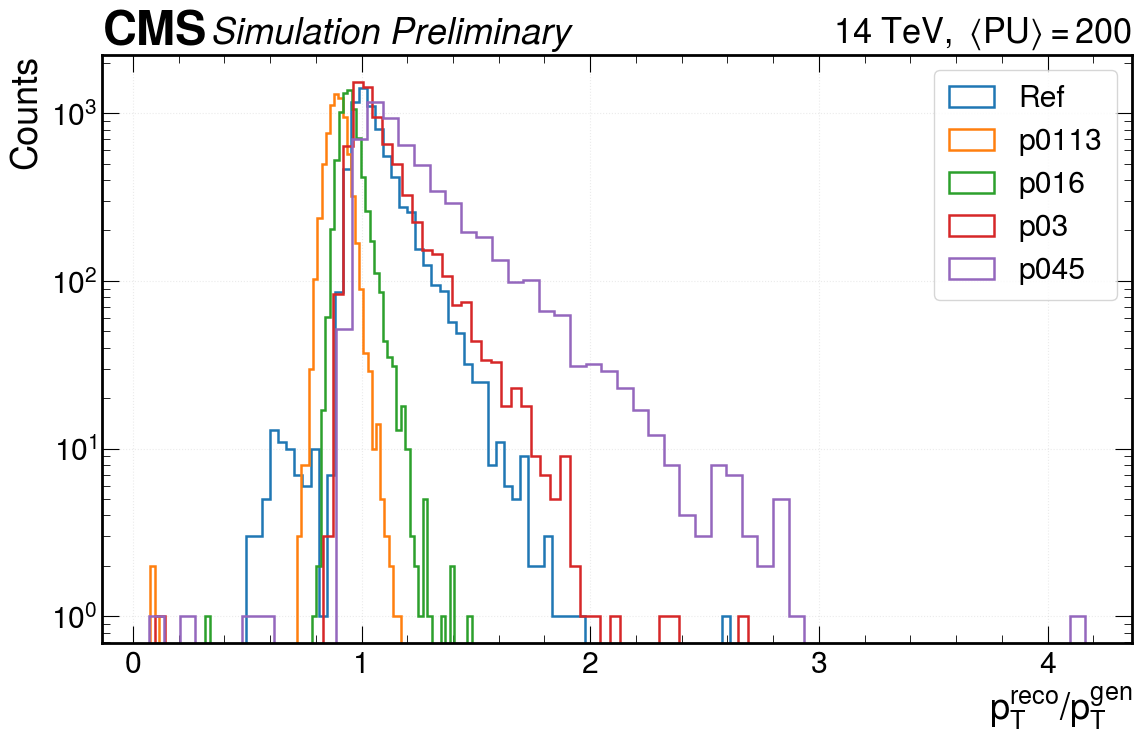

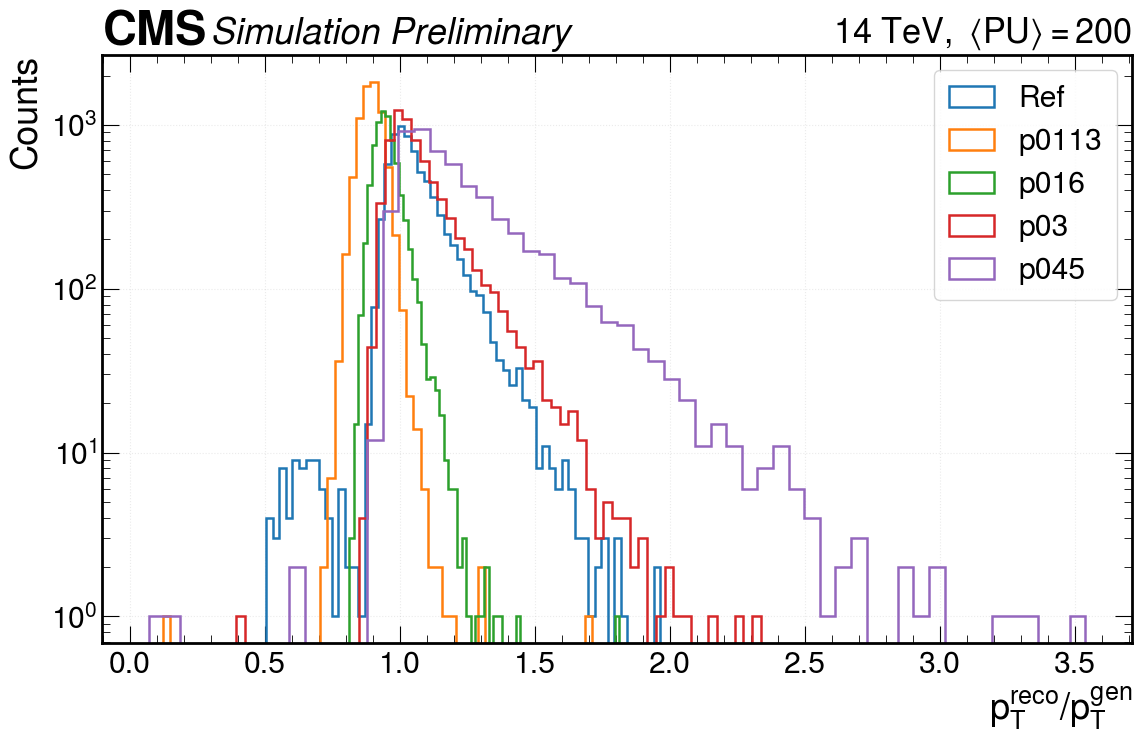

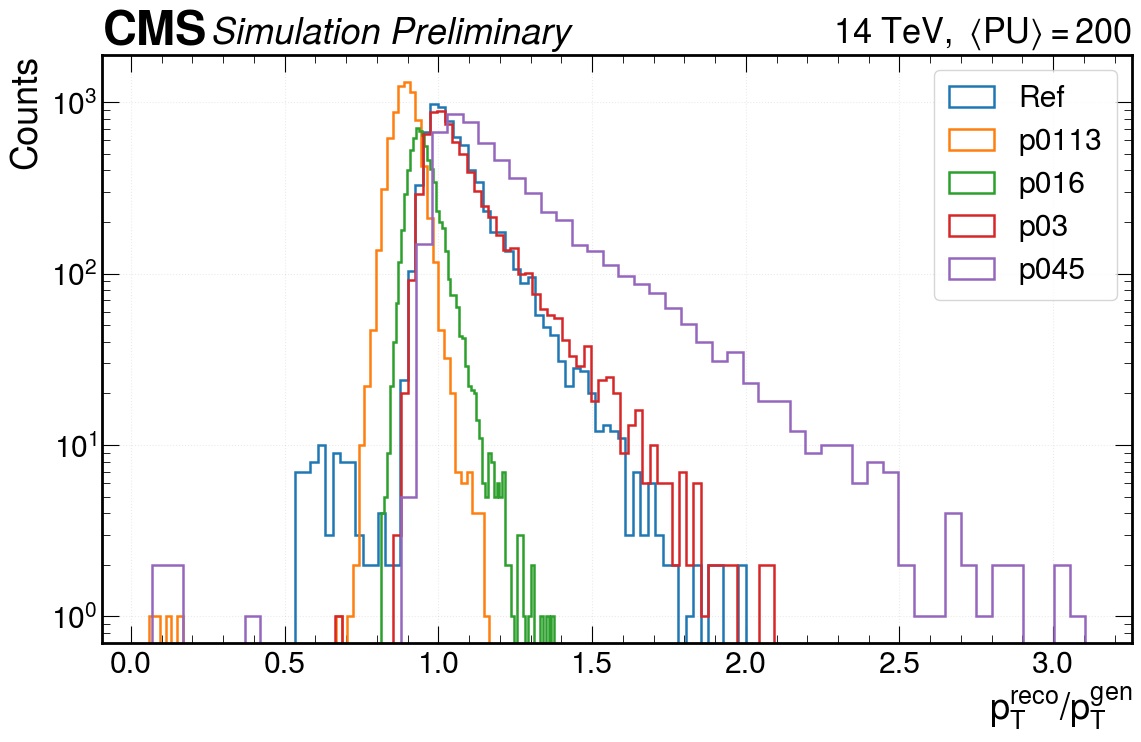

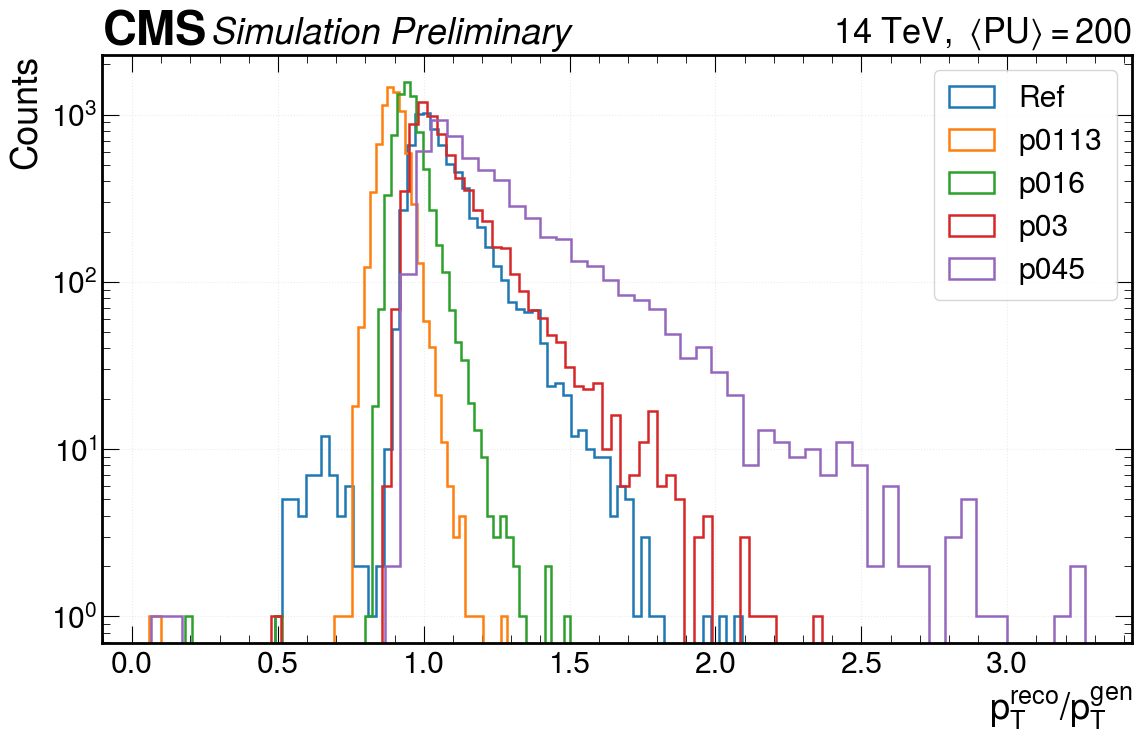

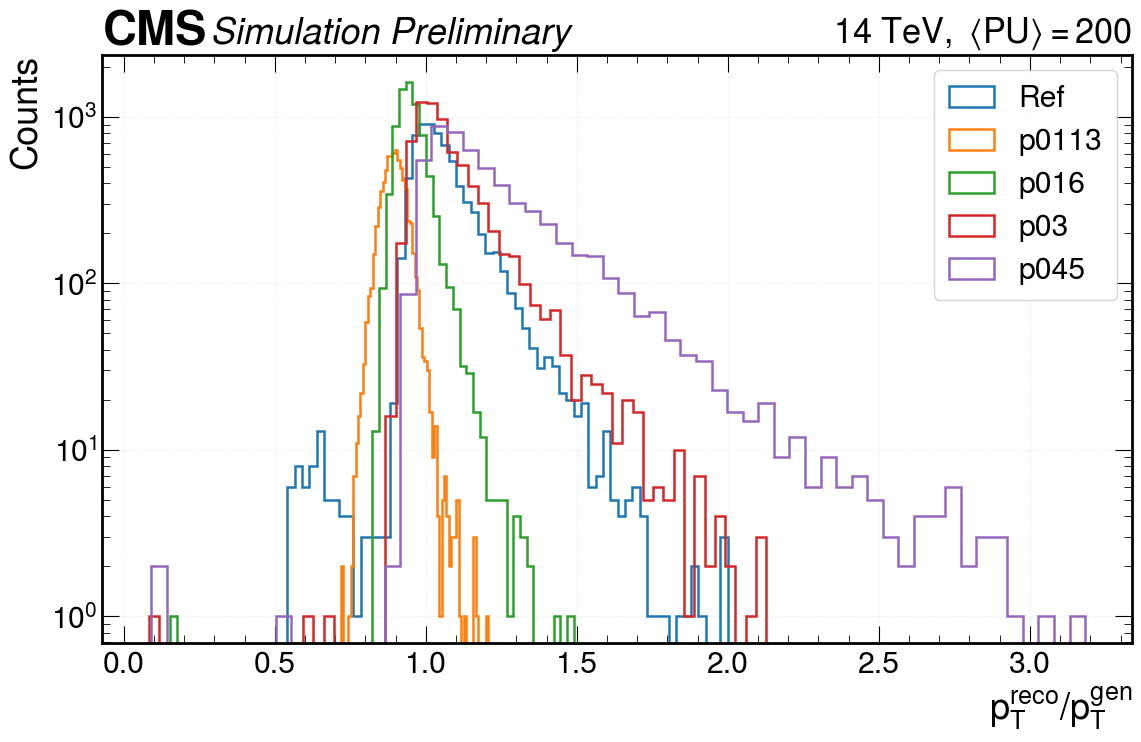

In [24]:
def wrap_phi(phi):
    return (phi + np.pi) % (2*np.pi) - np.pi

def _col(template, Prefix):
    return template.format(Prefix=Prefix)

def _bin_label(slice_var, lo, hi):
    if slice_var == "eta":
        return rf"{lo:.2f}<absEtaGen<{hi:.2f}"
    if slice_var == "pt":
        return rf"{lo:.0f}<ptGen<{hi:.0f}"
    if slice_var == "phi":
        return rf"{lo:.2f}<phiGen<{hi:.2f}"
    return rf"{lo}<x<{hi}"

def plot_response_hists_one_by_one(
    dfs,                         # dict: label -> (df, Prefix)
    slice_var,                   # "eta" | "pt" | "phi"
    slice_bins,                  # edges for that variable
    gen_eta_col="genpart_exeta",
    gen_pt_col="gen_pt",
    gen_phi_col="genpart_exphi",
    pt_reco_col="cl3d_{Prefix}_pt",
    # optional global selections (applied in addition to slice)
    ptgen_sel=None,              # e.g. (20, 100)
    etagen_sel=None,             # e.g. (1.6, 2.8) on abs(eta)
    phigen_sel=None,             # e.g. (-pi, pi) on wrapped phi
    # histogram settings
    nbins=60,
    yscale="log",
    density=False,
    weights_col=None,
    # labels / output
    outdir="resp_hists",
    tag="",
    cms_label="Preliminary",
    right_label="PU200 photons",
    xlabel=r"$p_T^{reco}/p_T^{gen}$",
):
    os.makedirs(outdir, exist_ok=True)

    slice_bins = np.asarray(slice_bins)
    for i in range(len(slice_bins) - 1):
        lo, hi = slice_bins[i], slice_bins[i+1]

        fig, ax = plt.subplots(figsize=(12,8))

        for lab, (df, Prefix) in dfs.items():
            pt_col = _col(pt_reco_col, Prefix)
            if pt_col not in df.columns:
                print(f"[WARN] {lab}: missing {pt_col}, skipping")
                continue

            eta = df[gen_eta_col].to_numpy()
            ptg = df[gen_pt_col].to_numpy()
            phi = wrap_phi(df[gen_phi_col].to_numpy())
            ptr = df[pt_col].to_numpy()

            m = np.isfinite(eta) & np.isfinite(ptg) & np.isfinite(phi) & np.isfinite(ptr)

            # global selections
            if ptgen_sel is not None:
                m &= (ptg >= ptgen_sel[0]) & (ptg < ptgen_sel[1])
            if etagen_sel is not None:
                m &= (np.abs(eta) >= etagen_sel[0]) & (np.abs(eta) < etagen_sel[1])
            if phigen_sel is not None:
                m &= (phi >= phigen_sel[0]) & (phi < phigen_sel[1])

            # slice selection
            if slice_var == "eta":
                m &= (np.abs(eta) >= lo) & (np.abs(eta) < hi)
                bin_text = rf"${lo:.2f} < |\eta^{{gen}}| < {hi:.2f}$"
            elif slice_var == "pt":
                m &= (ptg >= lo) & (ptg < hi)
                bin_text = rf"${lo:.0f} < p_T^{{gen}} < {hi:.0f}\ \mathrm{{GeV}}$"
            elif slice_var == "phi":
                m &= (phi >= lo) & (phi < hi)
                bin_text = rf"${lo:.2f} < \phi^{{gen}} < {hi:.2f}$"
            else:
                raise ValueError("slice_var must be 'eta', 'pt', or 'phi'")

            if not np.any(m):
                continue

            resp = ptr[m] / ptg[m]
            w = None
            if weights_col is not None:
                w = df.loc[m, weights_col].to_numpy()

            ax.hist(
                resp,
                bins=nbins,
                histtype="step",
                linewidth=1.8,
                density=density,
                weights=w,
                label=lab,
            )

        ax.set_yscale(yscale)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Counts" if not density else "A.U.")
        ax.grid(True, alpha=0.25)

        mh.cms.label(cms_label, data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")

        ax.legend(frameon=True, loc="upper right")
        fig.tight_layout()

        fname = f"resp_{slice_var}_{_bin_label(slice_var, lo, hi)}{tag}.png"
        fig.savefig(os.path.join(outdir, fname), bbox_inches="tight")
        plt.show()
        plt.close(fig)
dfs = {
    "Ref":   (photon_df_Ref_filtered,   "Ref"),
    "p0113": (photon_df_p0113_filtered, "p0113Tri"),
    "p016":  (photon_df_p016_filtered,  "p016Tri"),
    "p03":   (photon_df_p03_filtered,   "p03Tri"),
    "p045":  (photon_df_p045_filtered,  "p045Tri"),
}

eta_bins = [1.60, 1.86, 2.12, 2.25, 2.51, 2.80]
pt_bins  = [20, 30, 40, 50, 60, 80, 100]
phi_bins = np.linspace(-np.pi, np.pi, 7)

common = dict(
    gen_eta_col="genpart_exeta",
    gen_pt_col="gen_pt",
    gen_phi_col="genpart_exphi",
    pt_reco_col="cl3d_{Prefix}_pt",   # ✅ uses Prefix from dfs tuples
    nbins=60,
    yscale="log",
    cms_label="Preliminary",
    right_label="PU200 photons",
    ptgen_sel=(20, 100),              # optional global cut (applied to all)
    outdir="resp_hists",
)

# # 1) one plot per |etaGen| bin
plot_response_hists_one_by_one(dfs, "eta", eta_bins, tag="_etaBins", **common)

# # 2) one plot per ptGen bin
plot_response_hists_one_by_one(dfs, "pt",  pt_bins,  tag="_ptBins",  **common)

# 3) one plot per phiGen bin
plot_response_hists_one_by_one(dfs, "phi", phi_bins, tag="_phiBins", **common)


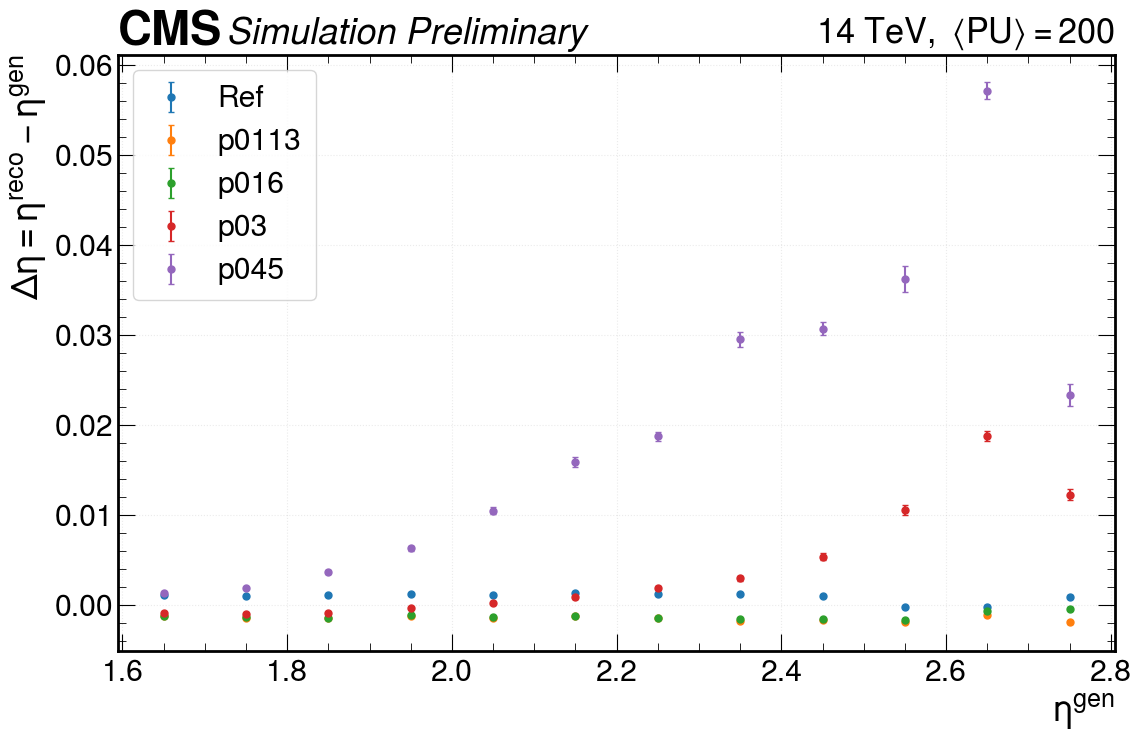

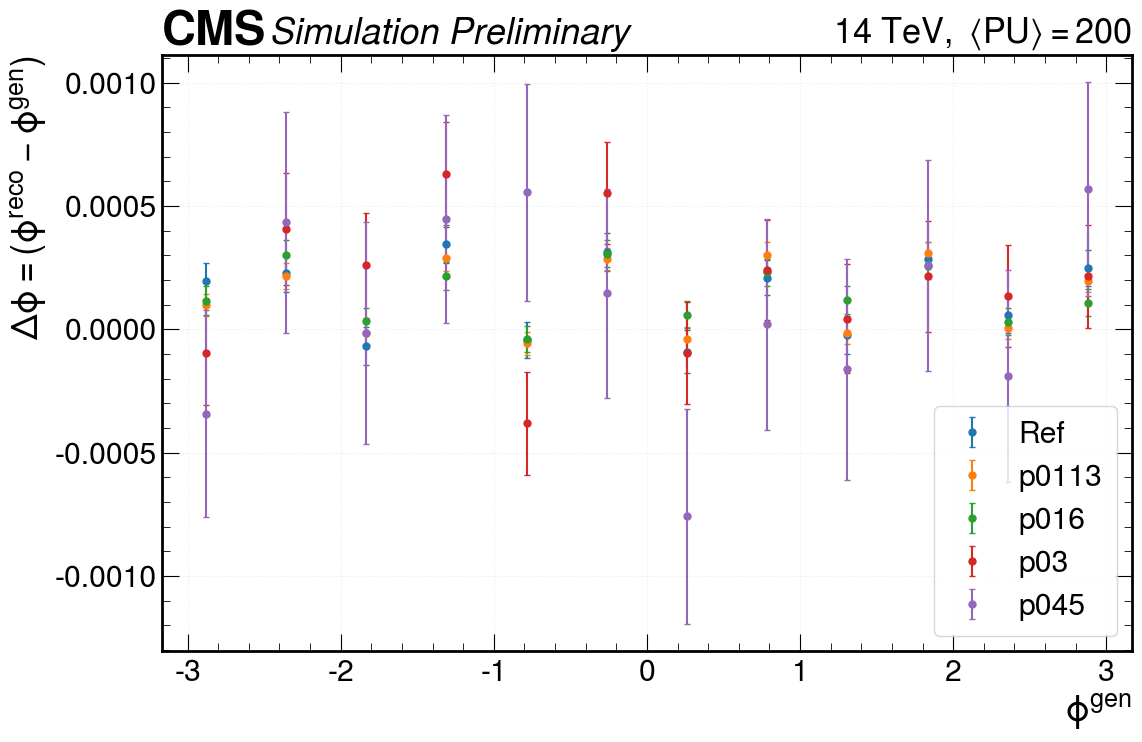

In [ ]:
def wrap_phi(phi):
    return (phi + np.pi) % (2*np.pi) - np.pi

def _col(template, Prefix):
    return template.format(Prefix=Prefix)

def binned_mean_sem(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    ib = np.digitize(x, bins) - 1
    nb = len(bins) - 1
    xc = 0.5 * (np.asarray(bins[:-1]) + np.asarray(bins[1:]))

    mean = np.full(nb, np.nan)
    sem  = np.full(nb, np.nan)
    n    = np.zeros(nb, dtype=int)

    for b in range(nb):
        yy = y[ib == b]
        n[b] = yy.size
        if yy.size:
            mean[b] = np.mean(yy)
            sem[b]  = (np.std(yy, ddof=1) / np.sqrt(yy.size)) if yy.size > 1 else 0.0
    return xc, mean, sem, n

def plot_delta_vs_gen(
    dfs,                          # dict: label -> (df, Prefix)
    which="eta",                  # "eta" or "phi"
    gen_eta_col="genpart_exeta",
    gen_phi_col="genpart_exphi",
    reco_eta_col="cl3d_{Prefix}_eta",
    reco_phi_col="cl3d_{Prefix}_phi",
    eta_bins=np.linspace(1.6, 2.8, 10),
    phi_bins=np.linspace(-np.pi, np.pi, 7),
    ptgen_sel=None,               # optional (lo,hi) on gen_pt
    gen_pt_col="gen_pt",
    outpath=None,
    cms_label="Preliminary",
):
    fig, ax = plt.subplots(figsize=(12,8))

    for lab, (df, Prefix) in dfs.items():
        if which == "eta":
            x = df[gen_eta_col].to_numpy()
            reco_col = _col(reco_eta_col, Prefix)
            if reco_col not in df.columns:
                print(f"[WARN] {lab}: missing {reco_col}, skipping")
                continue
            y = df[reco_col].to_numpy() - x
            bins = np.asarray(eta_bins)
            xlabel = r"$\eta^{gen}$"
            ylabel = r"$\Delta\eta  = \eta^{reco} - \eta^{gen}$"
            #hline = 0.0

        elif which == "phi":
            x = wrap_phi(df[gen_phi_col].to_numpy())
            reco_col = _col(reco_phi_col, Prefix)
            if reco_col not in df.columns:
                print(f"[WARN] {lab}: missing {reco_col}, skipping")
                continue
            y = wrap_phi(df[reco_col].to_numpy() - df[gen_phi_col].to_numpy())
            bins = np.asarray(phi_bins)
            xlabel = r"$\phi^{gen}$"
            ylabel = r"$\Delta\phi =  (\phi^{reco}-\phi^{gen})$"
            #hline = 0.0
        else:
            raise ValueError("which must be 'eta' or 'phi'")

        m = np.isfinite(x) & np.isfinite(y)

        if ptgen_sel is not None:
            ptg = df[gen_pt_col].to_numpy()
            m &= np.isfinite(ptg) & (ptg >= ptgen_sel[0]) & (ptg < ptgen_sel[1])

        xc, ym, ye, n = binned_mean_sem(x[m], y[m], bins)
        ok = np.isfinite(ym)
        ax.errorbar(xc[ok], ym[ok], yerr=ye[ok], fmt="o", ms=5, capsize=2, label=lab)

    #ax.axhline(hline, lw=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

    mh.cms.label(cms_label, data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")
    ax.legend(frameon=True)

    fig.tight_layout()
    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()


eta_bins = abs(np.linspace(1.6, 2.9, 14))         # or whatever you want
phi_bins = np.linspace(-np.pi, np.pi, 13)

plot_delta_vs_gen(
    dfs, which="eta",
    gen_eta_col="genpart_exeta",
    reco_eta_col="cl3d_{Prefix}_eta",
    eta_bins=eta_bins,
    ptgen_sel=(20, 100),
    outpath="dEta_vs_etaGen.png",
)

plot_delta_vs_gen(
    dfs, which="phi",
    gen_phi_col="genpart_exphi",
    reco_phi_col="cl3d_{Prefix}_phi",
    phi_bins=phi_bins,
    ptgen_sel=(20, 100),
    outpath="dPhi_vs_phiGen.png",
)


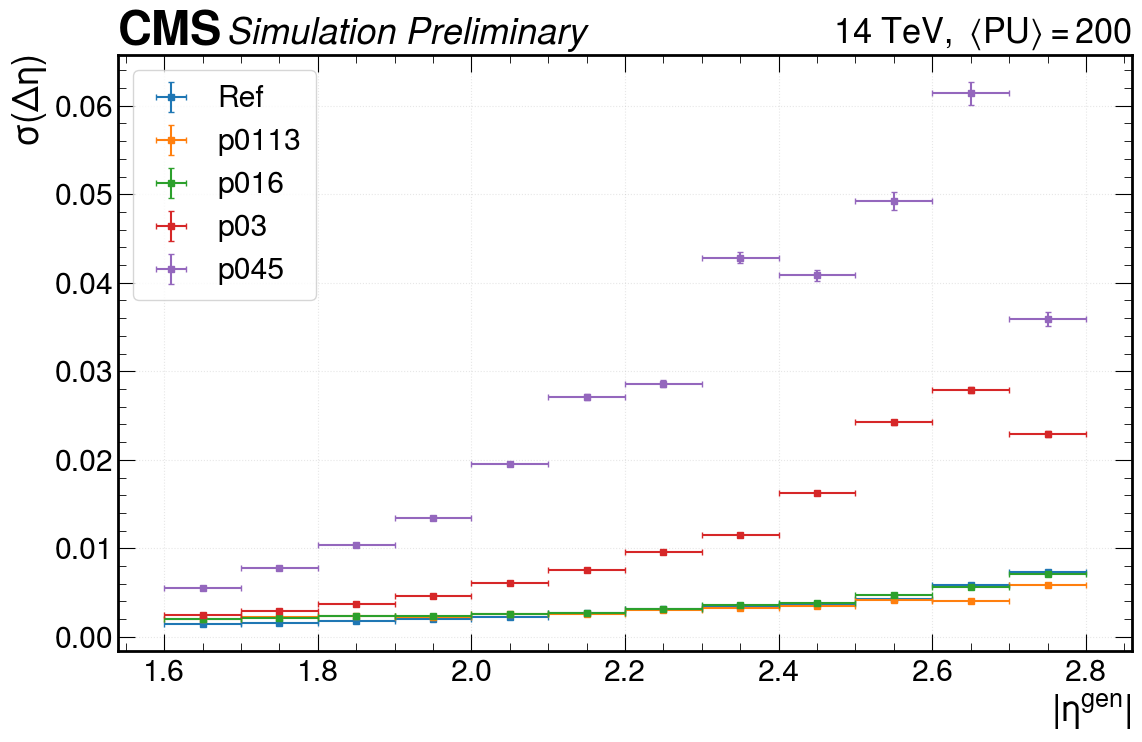

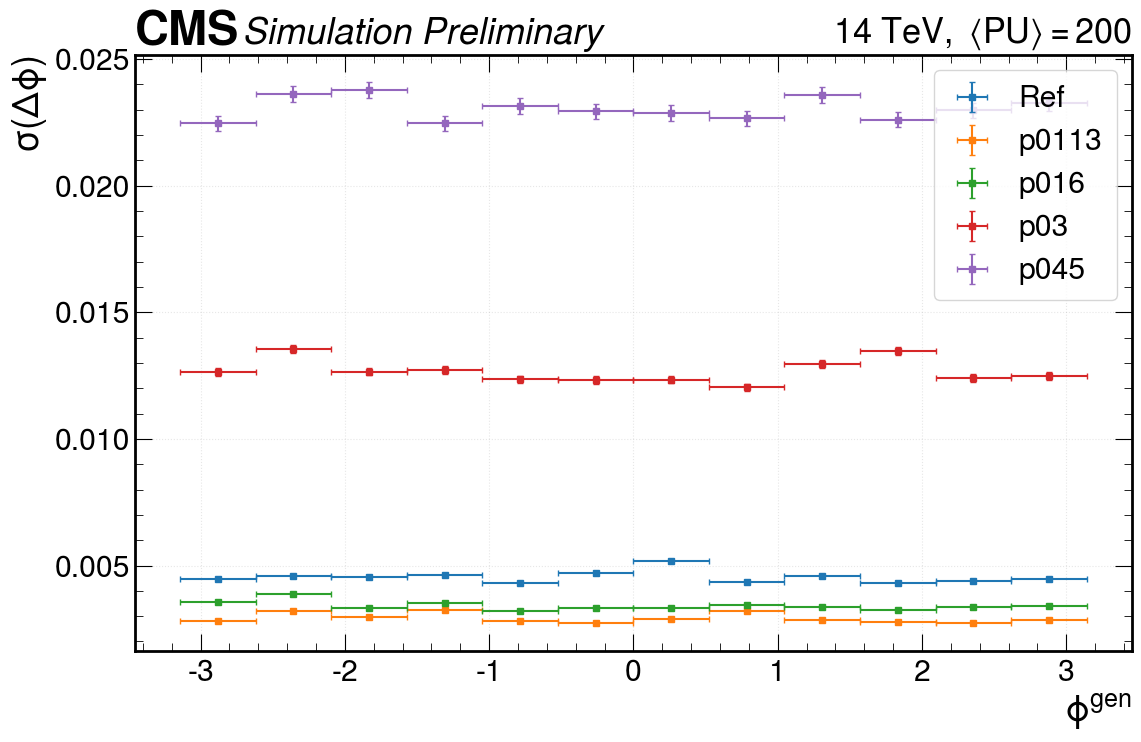

In [ ]:
def binned_rms_and_err(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    bins = np.asarray(bins)
    nb = len(bins) - 1
    xc = 0.5 * (bins[:-1] + bins[1:])
    xerr = 0.5 * (bins[1:] - bins[:-1])

    rms = np.full(nb, np.nan)
    er  = np.full(nb, np.nan)
    n   = np.zeros(nb, dtype=int)

    ib = np.digitize(x, bins) - 1
    for b in range(nb):
        yy = y[ib == b]
        n[b] = yy.size
        if yy.size >= 2:
            # RMS around mean (i.e. standard deviation)
            s = np.std(yy, ddof=1)
            rms[b] = s
            # approx error on std (Gaussian assumption)
            er[b] = s / np.sqrt(2*(yy.size - 1))
        elif yy.size == 1:
            rms[b] = 0.0
            er[b] = np.nan
    return xc, xerr, rms, er, n

def plot_sigma_delta_vs_gen(
    dfs,                           # dict: label -> (df, Prefix)
    which="phi",                   # "eta" or "phi"
    # gen columns
    gen_eta_col="genpart_exeta",
    gen_phi_col="genpart_exphi",
    gen_pt_col="gen_pt",
    # reco columns templates
    reco_eta_col="cl3d_{Prefix}_eta",
    reco_phi_col="cl3d_{Prefix}_phi",
    # binning
    eta_bins=np.linspace(1.6, 2.8, 13),          # for |eta|
    phi_bins=np.linspace(-np.pi, np.pi, 13),     # for phi
    use_abs_eta=True,
    # selection
    ptgen_sel=(20, 100),
    # cosmetics
    ylabel_eta=r"$\sigma(\Delta\eta)$",
    ylabel_phi=r"$\sigma(\Delta\phi)$",
    cms_label="Preliminary",
    right_label="PU200 photons",
    outpath=None,
):
    fig, ax = plt.subplots(figsize=(12, 8))

    for lab, (df, Prefix) in dfs.items():
        if which == "eta":
            reco_col = _col(reco_eta_col, Prefix)
            if reco_col not in df.columns:
                print(f"[WARN] {lab}: missing {reco_col}, skipping")
                continue
            eta_gen = df[gen_eta_col].to_numpy()
            eta_rec = df[reco_col].to_numpy()
            x = np.abs(eta_gen) if use_abs_eta else eta_gen
            y = eta_rec - eta_gen
            bins = np.asarray(eta_bins)
            xlabel = r"$|\eta^{gen}|$" if use_abs_eta else r"$\eta^{gen}$"
            ylabel = ylabel_eta

        elif which == "phi":
            reco_col = _col(reco_phi_col, Prefix)
            if reco_col not in df.columns:
                print(f"[WARN] {lab}: missing {reco_col}, skipping")
                continue
            phi_gen = wrap_phi(df[gen_phi_col].to_numpy())
            phi_rec = wrap_phi(df[reco_col].to_numpy())
            x = phi_gen
            y = wrap_phi(phi_rec - phi_gen)
            bins = np.asarray(phi_bins)
            xlabel = r"$\phi^{gen}$"
            ylabel = ylabel_phi

        else:
            raise ValueError("which must be 'eta' or 'phi'")

        ptg = df[gen_pt_col].to_numpy()
        m = np.isfinite(x) & np.isfinite(y) & np.isfinite(ptg)
        if ptgen_sel is not None:
            m &= (ptg >= ptgen_sel[0]) & (ptg < ptgen_sel[1])

        xc, xerr, sig, sigerr, n = binned_rms_and_err(x[m], y[m], bins)
        ok = np.isfinite(sig)

        ax.errorbar(
            xc[ok], sig[ok],
            xerr=xerr[ok], yerr=sigerr[ok],
            fmt="s", ms=5, capsize=2,
            label=lab
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    mh.cms.label(cms_label, data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")
    ax.legend(frameon=True)

    fig.tight_layout()
    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()


# -------------------------
# Example calls (match your request)
# -------------------------
eta_bins = np.linspace(1.6, 2.8, 13)
phi_bins = np.linspace(-np.pi, np.pi, 13)

plot_sigma_delta_vs_gen(
    dfs, which="eta",
    gen_eta_col="genpart_exeta",
    gen_pt_col="gen_pt",
    reco_eta_col="cl3d_{Prefix}_eta",
    eta_bins=eta_bins,
    use_abs_eta=True,
    ptgen_sel=(20, 100),
    outpath="sigma_dEta_vs_absEtaGen.png",
    right_label="PU200 photons",
)

plot_sigma_delta_vs_gen(
    dfs, which="phi",
    gen_phi_col="genpart_exphi",
    gen_pt_col="gen_pt",
    reco_phi_col="cl3d_{Prefix}_phi",
    phi_bins=phi_bins,
    ptgen_sel=(20, 100),
    outpath="sigma_dPhi_vs_phiGen.png",
    right_label="PU200 photons",
)
